<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

>[BUILDING FLOOR RECOGNITION](#scrollTo=SsIKuyArEu5c)

>[setup](#scrollTo=nogA7rji8GbZ)

>[utils](#scrollTo=1o3-BVUy8-sF)

>[Data](#scrollTo=pk-sYaYF7U9Y)

>>[Clean Data source](#scrollTo=uHL0auVWCnL6)

>>[Fetch cleaned dataset](#scrollTo=ALAyxPryCqFZ)

>>[sample audio](#scrollTo=w9GlJyvB2SoK)

>>[Modalities experimentations](#scrollTo=t46qlhPe2vHq)

>>>[Raw](#scrollTo=9ZMbXtvfG7Sa)

>>>[Spectrogram](#scrollTo=BAQnayGxG9vz)

>>>[MFCC](#scrollTo=b5Vm59MxHBYF)

>[Preprocessing & Packaging](#scrollTo=vg4POlOg2W6W)

>>[Waveform](#scrollTo=4jVjfEH_58rV)

>>[Spectrogram](#scrollTo=sHgonxaM55bk)

>>[MFCC](#scrollTo=zgxrq6hy512E)

>>[Spectrogram Image](#scrollTo=zHJDrkAhh522)

>>[Dataset creation](#scrollTo=9fs5X3NsPoZC)

>[Models](#scrollTo=PqSY1g2A2Yop)

>>[Pretrained](#scrollTo=mgXcolX4i9wc)

>>[SimpleNet](#scrollTo=2VMz6UQNvOzu)

>>[M5](#scrollTo=VBk4K9jdvRnQ)

>>[2d-CNN](#scrollTo=2bE-6QvuyNRH)

>[Training](#scrollTo=-b6VY1rH4Yrq)

>>[utils](#scrollTo=C47C65anl7y7)

>>[Spectrogram](#scrollTo=7anZNvPQmhzw)

>>>[Training](#scrollTo=tJxMkoJA-Jt-)

>>>[Evaluation](#scrollTo=i3H0iI0tshqr)

>>[Raw audio](#scrollTo=AgU0S5cWgpi9)

>[Results](#scrollTo=DsWDErTBXs3L)



# BUILDING FLOOR RECOGNITION

Inspired by https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb

In [ ]:
# https://stats.stackexchange.com/questions/559009/why-convert-spectrogram-to-rgb-for-machine-learning

same buildings recording shall not be distributed between train and test sets


Remember:

* Train with more data
* Data Augmentation
* adding noise to the input and ouput data
* feature selection
* cross-validation
* simplify data
* regularization
* ensembling
* early stopping
* adding dropout layers


# setup

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.autograd import Variable
from torch import nn

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cu113
0.12.0+cu113


In [ ]:
import random 
import os
from copy import deepcopy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from IPython.display import Audio, display
from typing import Dict,Any

In [ ]:
import librosa


In [ ]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torchaudio.utils.sox_utils.set_seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(496)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from torchvision import datasets, models, transforms


In [ ]:
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: nprime. Use `wandb login --relogin` to force relogin


True

In [ ]:
# show current directory
!pwd

/content


# utils

In [ ]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)


def estimate_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  print('Approximated model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [ ]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [ ]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


# Data 

## Clean Data source

In [ ]:
# !zip -r Data_cleaned.zip Data/

In [ ]:
# !rm -r Data/R+1/
# !rm -r Data/R+5/

In [ ]:
# # Unzip dataset
# !wget https://aptikal.imag.fr/~amini/Data.zip 
# !unzip -o -qqq Data.zip
# !rm Data.zip
# !unzip -o -qqq Data/R+1.zip
# !rm Data/R+1.zip
# !unzip -o -qqq Data/R+5.zip 
# !rm  -r Data/R+5.zip
# !rm -r Data

In [ ]:
# from pydub import AudioSegment 
# from pydub.utils import make_chunks
# import os

# def process_sudio(file_name):
#     myaudio = AudioSegment.from_file(file_name, "wav") 
#     chunk_length_ms = 5000 # pydub calculates in millisec 
#     chunks = make_chunks(myaudio,chunk_length_ms) #Make chunks of one sec 
#     # print(len(chunks[5]))
#     for i, chunk in enumerate(chunks):
#         if len(chunk)>4000:
#           chunk_name = './' + file_name + "_{0}.wav".format(i) 
#           print ("exporting", chunk_name) 
#           chunk.export(chunk_name, format="wav") 

# # all_file_names = os.listdir()
# # try:
# #     os.makedirs('chunked') # creating a folder named chunked
# # except:
# #     pass
# # for each_file in all_file_names:
# #     if ('.wav' in each_file):
# #         process_sudio(each_file)

In [ ]:

# path=os.path.join("/content","Data","R+1","CB01_1","Esquissons_CB01-1.wav")
# process_sudio(path)

In [ ]:
# from glob import glob 
# import re

# # This piece of code divide folders having multiple wav samples as another batiment samples

# os.chdir("/content/")
# for floor in [1,5]:
#   cur_dir=f"R+{floor}"
#   for (root,dirs,files) in os.walk(cur_dir):
#     for dir in dirs:
#       cur_bat = os.path.join(root,dir)
#       os.chdir(cur_bat)
#       if len(glob("*.wav"))==2:
#         os.chdir("/content/")
#         try:
#           os.mkdir(cur_bat+"_2")
#         except:
#           pass
#         all_files = glob(os.path.join(cur_bat,"*"+dir.split("_")[0]+"*_2*"))
#         _ = [os.rename(os.path.join(f) ,os.path.join(cur_bat+"_2",f.split("/")[-1])) for f in all_files]
#         os.rename(cur_bat,cur_bat+"_1")
#       os.chdir("/content/")
#     break

In [ ]:
# # Remove unused files 
# os.chdir("/content/")
# for floor in [1,5]:
#   cur_dir=f"R+{floor}"
#   for (root,dirs,files) in os.walk(cur_dir):
#     [os.remove(os.path.join(root,f)) for f in files if not (f.endswith(".wav"))]

In [ ]:
# # Store files in new folder Data
# !mkdir Data
# !mv R+1 Data/R+1
# !mv R+5 Data/R+5

In [ ]:
#!zip Data.zip -r Data

In [ ]:
# # split files 
# os.chdir("/content/Data")
# for floor in [1,5]:
#   cur_dir=os.path.join(f"R+{floor}")
#   for (root,dirs,files) in os.walk(cur_dir):
#     for f in files:
#       if f.endswith(".wav"):
#         process_sudio(os.path.join(root,f))
#         #d["samples"].append(os.path.join(root,f))
#         #d["floor"].append(floor)
# os.chdir("/content/")

In [ ]:
# d={"samples":[],"floor":[]}
# d2={"images":[],"floor":[]}

# os.chdir("/content/Data")
# for floor in [1,5]:
#   cur_dir=os.path.join(f"R+{floor}")
#   for (root,dirs,files) in os.walk(cur_dir):
#     for f in files:
#       #print(f)
#       if f.endswith("speccol.jpg"):
#         d2["images"].append(os.path.join(root,f))
#         d2["floor"].append(floor)
#       if ".wav_" in f:
#         #process_sudio(os.path.join(root,f))
#         d["samples"].append(os.path.join(root,f))
#         d["floor"].append(floor)
# os.chdir("/content/")

In [ ]:
# raw_dataset2 = pd.DataFrame.from_dict(d2)
# image_dataset = raw_dataset2.sample(frac=1).reset_index(drop=True)
# image_dataset.floor.replace({1:0,5:1},inplace=True)
# image_dataset.head()

In [ ]:
# # shuffle and replace labels
# raw_dataset = pd.DataFrame.from_dict(d)
# dataset = raw_dataset.sample(frac=1).reset_index(drop=True)
# dataset.to_csv("building_floor_recognition.csv",index=False)


## Fetch cleaned dataset

In [ ]:
!rm -r Data/
!rm building_floor_recognition_chunked.csv

rm: cannot remove 'Data/': No such file or directory
rm: cannot remove 'building_floor_recognition_chunked.csv': No such file or directory


In [ ]:
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_chunked.zip
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/building_floor_recognition_chunked.csv
!unzip -o -qqq Data_chunked.zip 
!rm Data_chunked.zip

--2022-07-15 13:58:52--  https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_chunked.zip
Resolving huggingface.co (huggingface.co)... 35.174.43.234, 54.84.221.13, 34.231.117.252, ...
Connecting to huggingface.co (huggingface.co)|35.174.43.234|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/45b6db69ad0ddd3d6107323868b6e707bbb572a465af1141d8a0a06117f9d6fe?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked.zip%22 [following]
--2022-07-15 13:58:52--  https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/45b6db69ad0ddd3d6107323868b6e707bbb572a465af1141d8a0a06117f9d6fe?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked.zip%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 52.85.132.50, 52.85.132.4, 52.85.132.1

In [ ]:
raw_dataset = pd.read_csv("building_floor_recognition_chunked.csv")
dataset = raw_dataset.copy()
dataset.floor.replace({1:0,5:1},inplace=True)
dataset.head(10)

,samples,floor
0,R+1/CB09_1/Esquissons_CB09_1.wav_1.wav,0
1,R+1/CB04_2/Esquissons_CB04_2.wav_1.wav,0
2,R+1/EC02/Esquissons_EC02.wav_2.wav,0
3,R+1/CB04_1/Esquissons_CB04_1.wav_3.wav,0
4,R+1/EC07-B/Esquissons_EC07B.wav_4.wav,0
5,R+1/FV06/Esquissons_FV06.wav_2.wav,0
6,R+1/FV06/Esquissons_FV06.wav_1.wav,0
7,R+5/CB03/Esquissons_CB03S01 wave.wav_3.wav,1
8,R+1/CB09_1/Esquissons_CB09_1.wav_2.wav,0
9,R+5/FV14/Esquissons_FV14 wave.wav_4.wav,1


In [ ]:
def clean(x):
  s=x.split("/")[1].split("_")
  if len(s)==3:
    return "_".join(s[:2])
  return s[0]

In [ ]:
clean("R+1/CB09_B_1/Esquissons_CB09_1.wav_1.wav	")

'CB09_B'

In [ ]:
raw_dataset.building.unique()

array(['CB09', 'CB04', 'EC02', 'EC07-B', 'FV06', 'CB03', 'FV14', 'FV11',
       'FV13_B', 'HS20', 'TIS06', 'CB02', 'VM06', 'VM04', 'VM02', 'CB01',
       'HS04', 'FV13', 'CB06', 'FV12'], dtype=object)

In [ ]:
raw_dataset.building.sample(2).values

array(['FV13', 'TIS06'], dtype=object)

In [ ]:
#raw_dataset[raw_dataset.building.isin(raw_dataset.building.sample(2).values)]

,samples,floor,building
0,R+1/CB09_1/Esquissons_CB09_1.wav_1.wav,1,CB09
1,R+1/CB04_2/Esquissons_CB04_2.wav_1.wav,1,CB04
2,R+1/EC02/Esquissons_EC02.wav_2.wav,1,EC02
3,R+1/CB04_1/Esquissons_CB04_1.wav_3.wav,1,CB04
4,R+1/EC07-B/Esquissons_EC07B.wav_4.wav,1,EC07-B
...,...,...,...
125,R+5/HS20/Esquissons_HS20S01 wave.wav_1.wav,5,HS20
126,R+1/CB04_2/Esquissons_CB04_2.wav_2.wav,1,CB04
127,R+1/CB01_1/Esquissons_CB01-1.wav_4.wav,1,CB01
128,R+1/EC02/Esquissons_EC02.wav_3.wav,1,EC02


In [ ]:
sum(dataset.floor)

60

In [ ]:
dataset.shape

(130, 2)

## sample audio

In [ ]:
# sample wav for testing purposes
sampled = raw_dataset.sample(1)
SAMPLE_WAV_PATH=os.path.join("/content","Data",sampled.samples.values[0])

In [ ]:
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=240000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [ ]:
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)

Sample Rate: 48000
Shape: (1, 240000)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.090

tensor([[-0.0055, -0.0050, -0.0060,  ...,  0.0043,  0.0046,  0.0036]])



In [ ]:
play_audio(waveform,sample_rate)
print("Etage ",sampled.floor.values[0])

Etage  1


Text(0.5, 1.0, 'Linear-frequency power spectrogram')

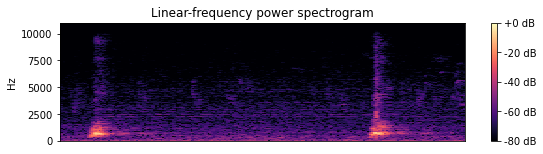

In [ ]:
import librosa.display

dat2, sampling_rate2 = librosa.load(os.path.join("/content/Data",sampled.samples.values[0]))
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
D.shape

(1025, 216)

In [ ]:

# path=os.path.join("/content","Data","R+1","CB01_2","Esquissons_CB01_2.wav")
# waveform,sample_rate = torchaudio.load(path,format="wav")
# play_audio(waveform,sample_rate)

## Modalities experimentations

### Raw

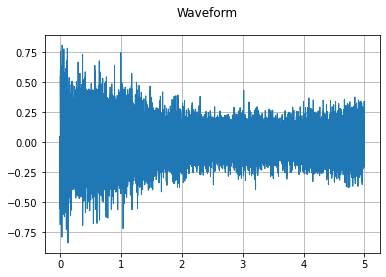

In [ ]:
# plot raw waveform

plot_waveform(waveform,sample_rate=sample_rate)

In [ ]:
waveform.shape

torch.Size([1, 240000])

In [ ]:
random.uniform(0.85,1.15)

0.8957131988789008

In [ ]:
random.choice([1.1,1.2])

1.1

In [ ]:

effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", str(random.choice([0.85,0.9,0.95,1.15,1.05]))],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ['gain', '-n', str(random.choice([-10,-5,0,5,10]))],  # apply 10 db attenuation

    ["rate", f"{sample_rate}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)


In [ ]:
sample_rate2

48000

In [ ]:
play_audio(waveform2,sample_rate2)

In [ ]:
play_audio(waveform2,sample_rate2)

### Spectrogram

Shape: (1, 513, 469)
Dtype: torch.float32
 - Max:     10745.065
 - Min:      0.000
 - Mean:     7.752
 - Std Dev: 88.868

tensor([[[1.2822e+03, 1.7746e+01, 9.7806e-02,  ..., 6.1072e+02,
          6.1545e+01, 3.8358e+00],
         [6.1719e+03, 2.5285e+03, 1.0559e+03,  ..., 1.2573e+03,
          3.0136e+02, 5.2158e+02],
         [6.5283e+03, 1.7567e+02, 6.4970e+03,  ..., 8.9981e+02,
          3.0965e+02, 7.9586e+02],
         ...,
         [3.4584e-04, 3.6509e-06, 1.9628e-05,  ..., 2.5860e-06,
          5.6876e-06, 8.7062e-06],
         [4.4212e-04, 1.1052e-05, 5.2339e-06,  ..., 5.9245e-06,
          1.7010e-06, 1.4502e-05],
         [5.4236e-04, 1.8804e-05, 8.7341e-08,  ..., 7.5315e-07,
          6.9131e-06, 4.3659e-05]]])

Shape: (1, 513, 469)
Dtype: torch.float32
 - Max:     27.982
 - Min:      0.000
 - Mean:     0.020
 - Std Dev:  0.231

tensor([[[3.3391e+00, 4.6212e-02, 2.5470e-04,  ..., 1.5904e+00,
          1.6027e-01, 9.9891e-03],
         [1.6073e+01, 6.5847e+00, 2.7497e+00,  ..

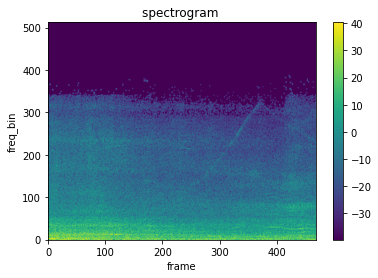

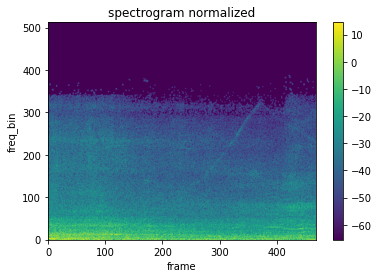

In [ ]:
n_fft = 1024
win_length = 1024
hop_length = None

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=False,
)

# define transformation
spectrogram_norm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True,
)
# Perform transformation
spec1 = spectrogram(waveform)
# Perform transformation
spec2 = spectrogram_norm(waveform)


print_stats(spec1)
print_stats(spec2)
plot_spectrogram(spec1[0], title='spectrogram ')
plot_spectrogram(spec2[0], title='spectrogram normalized')

In [ ]:
spec2[0].max()

tensor(27.9819)

In [ ]:
spec1[0].max()

tensor(1937.2036)

### MFCC

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape: (1, 256, 469)
Dtype: torch.float32
 - Max:     228.915
 - Min:     -101.217
 - Mean:    -1.857
 - Std Dev: 16.609

tensor([[[ 1.1824e+02,  1.1472e+02,  1.0267e+02,  ...,  2.6953e+01,
           2.8258e+01,  3.3695e+01],
         [ 2.0323e+02,  2.0776e+02,  2.0250e+02,  ...,  1.9621e+02,
           1.9578e+02,  1.9726e+02],
         [-2.5724e+01, -4.7699e+01, -6.8641e+01,  ..., -8.8659e+01,
          -8.3358e+01, -6.2585e+01],
         ...,
         [ 1.0194e+00,  3.4235e-01,  1.9248e-01,  ...,  5.1417e+00,
           5.1706e+00,  4.1359e+00],
         [ 7.2006e-01, -8.5570e-01,  7.9769e-01,  ...,  4.1625e+00,
           2.8351e+00, -2.5812e-01],
         [ 3.3689e+00,  3.1818e+00,  1.8827e+00,  ...,  1.6056e+00,
           2.1591e+00,  7.9510e-01]]])



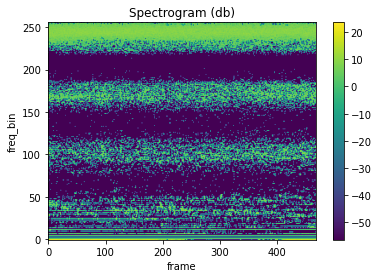

In [ ]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

In [ ]:
from torchaudio.transforms import MFCC

In [ ]:
def clean_mfcc(data):
  pass

def clean_spectrogram(data):
  pass

# Preprocessing & Packaging

check 
* https://jonathanbgn.com/2021/08/30/audio-augmentation.html
* https://developers.deepgram.com/blog/2022/06/pytorch-intro-with-torchaudio/

## Waveform

In [ ]:
class SoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList,transform = False):
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        self.transform = transform
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i,1] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i,1])
                #self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
         #self.mixer = torchaudio.transforms.DownmixMono() 
        self.folderList = folderList
        
    def __getitem__(self, index):
        #format the file path and load the file
        path = self.file_path + self.file_names[index]
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
        sound ,sample_rate = torchaudio.load(path, normalize = True)
        #print(sound.shape)
        # apply some effects : https://pytorch.org/tutorials//beginner/audio_data_augmentation_tutorial.html
        if self.transform:
          effects = [
              #["lowpass", "-1", "300"],  # apply single-pole lowpass filter
              ["speed", str(random.choice([0.95,1,1.05]))],  # reduce the speed
              # This only changes sample rate, so it is necessary to
              # add `rate` effect with original sample rate after this.
              ['gain', '-n', str(random.choice([-5,-2.5,0,2.5,5]))],  # apply 10 db attenuation

              ["rate", f"{sample_rate}"],
              #["reverb", "-w"],  # Reverbration gives some dramatic feeling
          ]
          # # Apply effects
          sound, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(sound, sample_rate, effects)
          #print(sound.shape)
          sound = torch.mean(sound, dim=0).unsqueeze(0) # #UrbanSound8K uses two channels, this will convert them to one
        soundData = sound
        #print(soundData.shape,soundData.numel())
        #downsample the audio to ~8kHz
        # 120000
        tempData = torch.zeros([200000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 200000:
            tempData[:soundData.numel()] = soundData[:].T
        else:
            tempData[:] = soundData[:,:200000].T
        
        soundData = tempData
        soundFormatted = torch.zeros([40000, 1])
        chunk = random.randint(0,4)
        soundFormatted[:40000] = soundData[::5]#take every sixth sample of soundData
        #soundFormatted = soundFormatted[chunk*40000:(chunk+1)*40000] #take a random chunk
        soundFormatted = soundFormatted.permute(1, 0)

        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)


## Spectrogram

In [ ]:
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# check also https://colab.research.google.com/github/enzokro/clck10/blob/master/_notebooks/2020-09-10-Normalizing-spectrograms-for-deep-learning.ipynb#scrollTo=VBD562J9i2AF
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled


def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - 1.15) / (27 + eps)
  #spec_min, spec_max = spec_norm.min(), spec_norm.max()
  #spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_norm

In [ ]:
class SpecSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_fft, win_length = None, center = True,transform = False, pad_mode = "reflect", power = 2.0,hop_length=None):
        super().__init__(csvData, file_path, folderList,transform)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._center = center
        self._pad_mode = pad_mode
        self._power = power
        # define transformation
        spectrogram = T.Spectrogram(
          n_fft= self._n_fft,
          win_length=self._win_length,
          hop_length=self._hop_length,
          center=self._center,
          pad_mode=self._pad_mode,
          power=self._power,
          normalized=False,
        )
        self._spec_mixer = spectrogram
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      transformed = self._spec_mixer(soundFormatted)
      #transformed[:] = (1-labels**2)+2*labels-5+random.uniform(0.0,0.3)
      # apply transformation
      return spec_to_image(transformed), labels

    
    def __len__(self):
        return len(self.file_names)

## MFCC

In [ ]:
# NORMALIZE VALUES
class MFCCSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_mfcc, sample_rate, n_fft = None, n_mels = None, mel_scale = 'htk'):
        super().__init__(csvData, file_path, folderList)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._n_mels = n_mels
        self._n_mfcc = n_mfcc 
        self._sample_rate = sample_rate
        self._mel_scale = mel_scale
        # define transformation
        
        mfcc_transform = T.MFCC(
            sample_rate= self._sample_rate,
            n_mfcc=self._n_mfcc,
            
            melkwargs={
              'n_fft': self._n_fft,
              'n_mels': self._n_mels,
              'hop_length': self._hop_length,
              'mel_scale': self._mel_scale,

            },
          
        )

        self._mfcc_transform = mfcc_transform
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._mfcc_transform(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

## Spectrogram Image

In [ ]:
# from PIL import Image

In [ ]:
# class SpecImageDataset(SoundDataset):
# #rapper for the UrbanSound8K dataset
#     # Argument List
#     #  path to the UrbanSound8K csv file
#     #  path to the UrbanSound8K audio files
#     #  list of folders to use in the dataset
    
#     def __init__(self, csvData, file_path, folderList,transform = None):
#         super().__init__(csvData, file_path, folderList,transform)
#         self.transform = transform
        
#     def __getitem__(self, index):
#       #print("ekie")
#       path = self.file_path + self.file_names[index]
#         #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
#       #sound ,sample_rate = torchaudio.load(path, normalize = True)

#       # img_name = Path(self.root_dir,
#       #                         self.roof_frame.iloc[idx, 1])
#       image = Image.open(path)
#       if self.transform:
#         image = self.transform(image)
#       return image, self.labels[index]

    
#     def __len__(self):
#         return len(self.file_names)

## Dataset creation

In [ ]:
os.chdir("/content/")

In [ ]:
csv_path = './building_floor_recognition.csv'
file_path = './Data/'

In [ ]:
X_train, X_test = train_test_split(dataset, test_size=0.2, stratify = dataset.floor)
X_train, X_val = train_test_split(X_train, test_size=0.2, stratify = X_train.floor)

In [ ]:

# # configure MFCC settings 
# config_spec_args = {
#     'n_fft':512,
#     'n_mfcc':180,
#     'sample_rate':8000,
#     'n_mels':180,

# }

# train_set = MFCCSoundDataset(X_train, file_path, range(0,6), **config_spec_args)
# test_set = MFCCSoundDataset(X_test, file_path, [10], **config_spec_args)

# Models

## Pretrained

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


## SimpleNet

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels = 128, kernel_size = 5, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size = 5, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

        
            nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(32,16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            # nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            nn.MaxPool2d(2,2),

            # nn.Conv2d(64,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),

            # nn.Conv2d(128,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9072,128),
            nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            nn.Linear(128,n_output),
            # nn.Softmax(),
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


## M5

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


## 2d-CNN

In [ ]:
# https://www.kaggle.com/code/mhiro2/simple-2d-cnn-classifier-with-pytorch/notebook


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            #nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

In [ ]:
# net=SimpleNet()

In [ ]:
# train_set[0][0].unsqueeze(0).shape

In [ ]:
# conv= nn.Conv1d(1, out_channels = 32, kernel_size = 3, padding = 1)

In [ ]:
# net(train_set[0][0].unsqueeze(0))

In [ ]:
class MFCCClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [ ]:
class Rawlassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [ ]:
class SpectrogramClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [ ]:
class LateFusionClassifier(nn.Module):
  # Model used in late fusion classification
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

In [ ]:
class EarlyFusionClassifier(nn.Module):
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

# Training

## utils

In [ ]:
# Reporting strategies

class Reporter:
  """
    proxy used for any reporter ( wandb, tensorboard, etc)
  """
  def __init__(self):
    pass

  def log(self,data:Dict[str, Any]):
    raise NotImplementedError

  def stop(self):
    raise NotImplementedError
  def start(self,**kwargs):
    raise NotImplementedError

class WandbReporter(Reporter):
  """
    wand reporter with permanent storage and wandb dashboard
  """
  def __init__(self,wandb,**kwargs):
    super().__init__()
    self._wandb = wandb
    self._kwargs = kwargs
  
  def log(self,data:Dict[str, Any]):
    self._wandb.log(data)

  def stop(self):
    self._wandb.finish()

  def start(self,**kwargs):
    self._wandb.init(project="audio-classification",**self._kwargs)
    


class DummyReporter(Reporter):
  """
    quick reporter with non permanent storage
  """
  def __init__(self):
    self._data={}

  def log(self,data:Dict[str, Any]):
    for key in data.keys():
      if key in self._data:
        self._data[key].append(data[key])
      else:
        self._data[key]=[data[key]]

  def get(self,key):
    return self._data[key]

  def stop(self):
    pass

  def start(self,**kwargs):
    pass

In [ ]:
# Function to save the model
def saveModel(model,loss):
    #if not path:
    path = f"./bestModel.pth"
    torch.save(model.state_dict(), path)

In [ ]:
# Function to test the model with the test dataset and print the accuracy for the test images
def valid(model,test_loader,loss_fn,device=torch.device("cpu")):
    model.to(device)
    model.eval()
    accuracy = 0.0
    total = 0.0
    correct_true = 0.0
    predicted_true = 0.0
    target_true = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            #print(len(images))
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
          
            #print(outputs.data)
            loss = loss_fn(outputs, labels)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
            # target_true += torch.sum(labels == 0).float()
            # predicted_true += torch.sum(predicted).float()
            # correct_true += torch.sum(
            #     predicted == labels * predicted == 0).float()
        # recall = correct_true / target_true
        # precision = correct_true / predicted_true
        # f1_score = 2 * precision * recall / (precision + recall)

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return (loss.item(), accuracy)

In [ ]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model,train_loader,optimizer,loss_fn,train_steps=1000,device=torch.device("cpu"),reporter = None):
    
    best_accuracy = 0.0
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    
    running_loss = 0.0
    running_acc = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))


        # predict classes using images from the training set
        outputs = model(images)
        print(outputs.data)
        # print("labels=",labels)
        # compute the loss based on model output and real labels
        loss = loss_fn(outputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        #loss = F.nll_loss(outputs.squeeze(), labels)
        
        # backpropagate the loss
        loss.backward()

        # # https://discuss.pytorch.org/t/how-to-check-for-vanishing-exploding-gradients/9019
        for name, param in model.named_parameters():
          print(name, param.grad.norm())
        # adjust parameters based on the calculated gradients
        optimizer.step()

        # Let's print statistics for every 1,000 images
        running_loss += loss.item()     # extract the loss value
        if i % (train_steps) == (train_steps-1):    
            # print every 1000 (twice per epoch) 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / train_steps))
            if reporter:
                reporter.log({'train_loss':running_loss})
            # zero the loss
            running_loss = 0.0

    

In [ ]:
# # define a cross validation function
# def crossvalid(model=None,criterion=None,dataset=None,k_fold=5,device=torch.device("cpu"),num_epochs=1, train_steps=1,lr=3e-4):
    
#     train_score = pd.Series()
#     val_score = pd.Series()
    
#     total_size = len(dataset)
#     fraction = 1/k_fold
#     seg = int(total_size * fraction)
#     # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
#     # index: [trll,trlr],[vall,valr],[trrl,trrr]
#     for i in range(k_fold):
#         print(f"Fold {i+1} training")
#         trll = 0
#         trlr = i * seg
#         vall = trlr
#         valr = i * seg + seg
#         trrl = valr
#         trrr = total_size
        

#         print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
#                 % (trll,trlr,trrl,trrr,vall,valr))
 
#         train_left_indices = list(range(trll,trlr))
#         train_right_indices = list(range(trrl,trrr))
        
#         train_indices = train_left_indices + train_right_indices
#         val_indices = list(range(vall,valr))
        
#         train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
#         val_set = torch.utils.data.dataset.Subset(dataset,val_indices)


#         _train_loader = torch.utils.data.DataLoader(train_set, batch_size=5,shuffle=True)
#         _val_loader = torch.utils.data.DataLoader(val_set, batch_size=5,shuffle=True)
        
#         res_model = deepcopy(model)
#         _optimizer = torch.optim.Adam(res_model.parameters(), lr=lr)
#         train_acc = train(res_model,_train_loader,_optimizer,criterion,eval_loader=_val_loader,num_epochs = num_epochs, train_steps=train_steps,device=device)
#         train_score.at[i] = train_acc
#         val_acc = valid(res_model,_val_loader,criterion,device)
#         val_score.at[i] = val_acc
#         del res_model
    
#     return train_score,val_score

In [ ]:
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

## Spectrogram

### Training

check out https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc

In [ ]:
train_spectrogram = False

if train_spectrogram:
  # configure spectrogram settings 
  config_spec_args = {
      'n_fft':1024,
      'win_length':1024,
  }
  all_set = SpecSoundDataset(dataset, file_path, range(0,6),**config_spec_args)
  train_set = SpecSoundDataset(X_train, file_path, range(0,6),transform = False, **config_spec_args)
  val_set = SpecSoundDataset(X_val, file_path, range(0,6), **config_spec_args)
  test_set = SpecSoundDataset(X_test, file_path, range(0,6), **config_spec_args)

  print("All set size: " + str(len(all_set)))
  print("Train set size: " + str(len(train_set)))
  print("Val set size: " + str(len(val_set)))
  print("Test set size: " + str(len(test_set)))


  plot_spectrogram(train_set[8][0][0])

  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

  train_loader = torch.utils.data.DataLoader(train_set, batch_size = 30 , shuffle = True, **kwargs)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size = 30 , shuffle = True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = 30, shuffle = True, **kwargs)

In [ ]:
# train_score,val_score = crossvalid(net,loss_fn,dataset=all_set,device = device, k_fold=5, num_epochs = 20)

In [ ]:
# # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_name = "resnet"

# # Number of classes in the dataset
# num_classes = 2

# # Batch size for training (change depending on how much memory you have)
# batch_size = 8

# # Number of epochs to train for
# num_epochs = 15

# # Flag for feature extracting. When False, we finetune the whole model,
# #   when True we only update the reshaped layer params
# feature_extract = True
# # Initialize the model for this run
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# # Print the model we just instantiated
# print(model_ft)

In [ ]:
!set CUDA_LAUNCH_BLOCKING=1
os.chdir("/content/")

In [ ]:
if train_spectrogram:
  model = SimpleNet(in_channels=1,n_output=2)
  rate_learning = 1e-3
  optimizer = torch.optim.Adam(model.parameters(), lr=rate_learning)
  loss_fn = nn.CrossEntropyLoss()
  scheduler = ReduceLROnPlateau(optimizer, 'min',patience = 5,factor=0.5,verbose=True)
  num_epochs = 50
  early_stop = 100
  reporter = WandbReporter(wandb,name="spectrogram-standardization", config={"model":"simple_net_batchnorm","epochs": 4,"learning_rate":1e-1, "batch_size": 5, "reduce_plateau_factor":0.5,"reduce_on_plateau_patience":10,"chunked":True})
  print("The model will be running on", device, "device")

In [ ]:
def initialize_weights(m):
   # look at : https://androidkt.com/initialize-weight-bias-pytorch/
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [ ]:
# Initilialize model weights

model.apply(initialize_weights)

SimpleNet(
  (network): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, 

In [ ]:
# from torch_lr_finder import LRFinder
# lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")

In [ ]:

# lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="exp")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

In [ ]:

# means = []
# stds = []
# for i in range(100):
#   for img in train_set:
#       means.append(torch.mean(img[0]))
#       stds.append(torch.std(img[0]))

# mean = torch.mean(torch.tensor(means))
# std = torch.mean(torch.tensor(stds))

In [ ]:
# mean,std

In [ ]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
 
best_accuracy = 0.0
# Convert model parameters and buffers to CPU or Cuda
model.to(device)
best_loss = 1e7
count = 0
train_spectrogram = False

if train_spectrogram:
  if reporter:
    reporter.start()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      
      running_loss = train(model,train_loader,optimizer,loss_fn,train_steps=1,device=device,reporter=reporter)
      # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
      eval_loss, accuracy = valid(model,val_loader,loss_fn,device)
      print('Epoch[', epoch+1,'] eval accuracy %d %%' % (accuracy),"eval loss %.3f" % (eval_loss))
      if reporter:
        reporter.log({'eval_loss':eval_loss,'eval_accuracy':accuracy})
      
      # we want to save the model if the accuracy is the best
      if best_loss > eval_loss:
          print("Saving best model so far model eval loss = ",eval_loss)
          saveModel(model,eval_loss)
          best_loss = eval_loss
          count = 0 
      else:
        count += 1
      scheduler.step(eval_loss)
      
      if count>early_stop:
        print("Early Stopping loss did not improve for ",early_stop," epochs")
        break
      
  if reporter:
    reporter.stop()

Streaming output truncated to the last 5000 lines.
network.8.bias tensor(0.0505, device='cuda:0')
network.9.weight tensor(0.0098, device='cuda:0')
network.9.bias tensor(0.0637, device='cuda:0')
network.12.weight tensor(0.1512, device='cuda:0')
network.12.bias tensor(0.1145, device='cuda:0')
network.13.weight tensor(0.0139, device='cuda:0')
network.13.bias tensor(0.1139, device='cuda:0')
network.17.weight tensor(0.1305, device='cuda:0')
network.17.bias tensor(0.1072, device='cuda:0')
network.18.weight tensor(0.0172, device='cuda:0')
network.18.bias tensor(0.1452, device='cuda:0')
classifier.1.weight tensor(0.3160, device='cuda:0')
classifier.1.bias tensor(0.0176, device='cuda:0')
classifier.3.weight tensor(0.0754, device='cuda:0')
classifier.3.bias tensor(0.0273, device='cuda:0')
[19,     2] loss: 0.311
tensor([[-9.4831e-01,  3.2141e-01],
        [-3.7707e+00,  3.4890e+00],
        [-9.2288e-01,  3.3740e-01],
        [ 1.3168e+01, -6.3378e+00],
        [-7.4032e-01,  4.1351e-01],
      

eval_accuracy,▁█▇▇█▇▇███▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
eval_loss,▅▁▁▃▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████████████
train_loss,█▆▅▄▂▃▃▃▃▂▃▃▂▃▃▂▁▁▃▂▂▂▂▂▂▂▁▂▂▃▁▂▂▂▂▂▂▂▂▂
eval_accuracy,66.66667
eval_loss,2.13257
train_loss,0.21747


In [ ]:
# train(net,train_loader,optimizer,loss_fn,eval_loader=val_loader,num_epochs = 50,train_steps=1,device=device,reporter=None)

In [ ]:
def clean_gpu():
  import gc
  gc.collect() # Python thing
  torch.cuda.empty_cache()
clean_gpu()

In [ ]:
!nvidia-smi

Fri Jul 15 07:01:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W /  70W |   1302MiB / 15109MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Evaluation

In [ ]:
# loaded_model = SimpleNet(1,2)
# loaded_model.load_state_dict(torch.load("./bestModel.pth"))
# #loaded_model.eval()

<All keys matched successfully>

In [ ]:
# valid(loaded_model,val_loader,loss_fn,device)

(0.5228273868560791, 76.19047619047619)

In [ ]:
# valid(loaded_model,train_loader,loss_fn,device)

(0.474732369184494, 74.6987951807229)

In [ ]:
# valid(loaded_model,test_loader,loss_fn,device)

(0.5178467631340027, 73.07692307692308)

## Raw audio

# Results

In [ ]:
all_set = SoundDataset(dataset, file_path, range(0,6))
train_set = SoundDataset(X_train, file_path, range(0,6))
test_set = SoundDataset(X_test, file_path, range(0,6))

In [ ]:
print("All set size: " + str(len(all_set)))
print("Train set size: " + str(len(train_set)))
print("Val set size: " + str(len(val_set)))
print("Test set size: " + str(len(test_set)))


plot_spectrogram(train_set[8][0][0])

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 30 , shuffle = True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 30 , shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 30, shuffle = True, **kwargs)